In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox



In [57]:
# Membaca file CSV dan menghapus baris dengan NA
data = pd.read_csv("data1.csv").dropna()

# Ganti nama kolom
data.rename(columns={"NTP.Provinsi.Jambi": "NTP.JAMBI"}, inplace=True)


In [58]:
# Buat indeks waktu bulanan mulai Januari 2008
date_range = pd.date_range(start="2008-01", periods=len(data), freq='M')
data['date'] = date_range
data.set_index('date', inplace=True)

# Ambil kolom time series
data_ts = data['NTP.JAMBI']


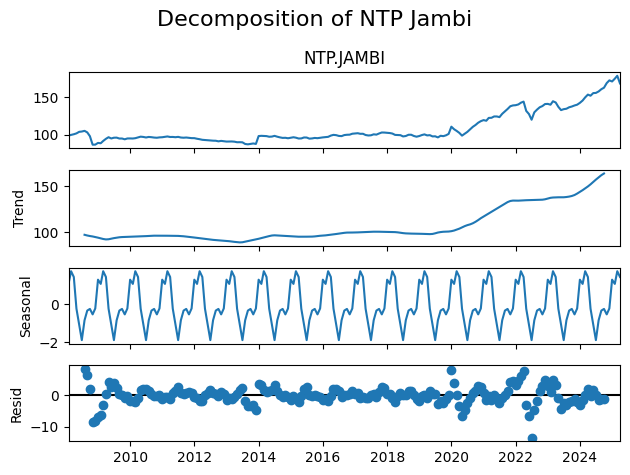

In [59]:
decomposition = seasonal_decompose(data_ts, model='additive', period=12)
decomposition.plot()
plt.suptitle("Decomposition of NTP Jambi", fontsize=16)
plt.tight_layout()
plt.show()


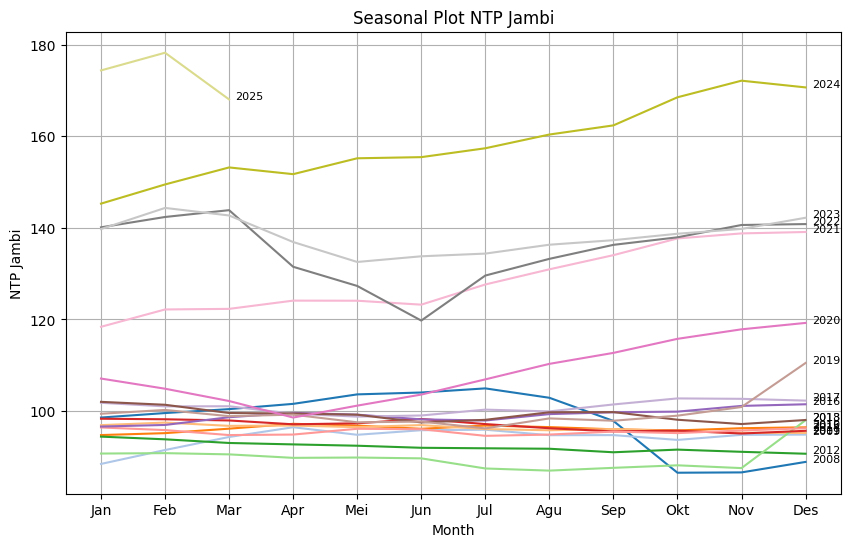

In [60]:
# Alternatif dari ggseasonplot di R
data['month'] = data.index.month
data['year'] = data.index.year

plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='month', y='NTP.JAMBI', hue='year', palette='tab20', legend=False)
for year in data['year'].unique():
    last_month = data[data['year'] == year]['month'].max()
    last_value = data[(data['year'] == year) & (data['month'] == last_month)]['NTP.JAMBI'].values[0]
    plt.text(last_month + 0.1, last_value, str(year), fontsize=8)

plt.title('Seasonal Plot NTP Jambi')
plt.xlabel('Month')
plt.ylabel('NTP Jambi')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])
plt.grid(True)
plt.show()


count    207.000000
mean     108.381739
std       21.209170
min       86.490000
25%       95.750000
50%       98.550000
75%      118.105000
max      178.280000
Name: NTP.JAMBI, dtype: float64
Variance: 449.8288998733644


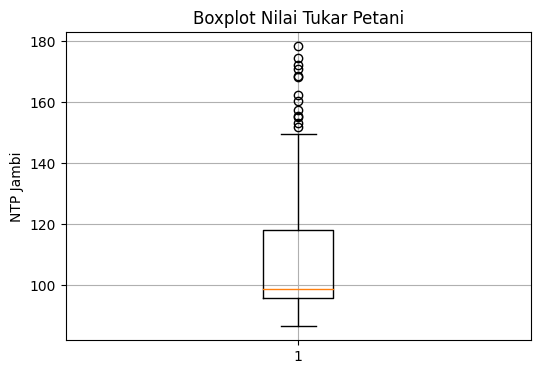

In [61]:
# Statistik deskriptif
print(data_ts.describe())

# Varians
print("Variance:", np.var(data_ts, ddof=1))  # ddof=1 untuk sample variance, sama seperti R

# Boxplot untuk deteksi outlier
plt.figure(figsize=(6, 4))
plt.boxplot(data_ts, vert=True)
plt.title("Boxplot Nilai Tukar Petani")
plt.ylabel("NTP Jambi")
plt.grid(True)
plt.show()


In [62]:
# Membagi data menjadi 80% training dan 20% testing
n = len(data_ts)
n_train = int(0.8 * n)

train = data_ts.iloc[:n_train]
test = data_ts.iloc[n_train:]

print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 165, Test size: 42


Nilai lambda terbaik (Box-Cox): -5.4421


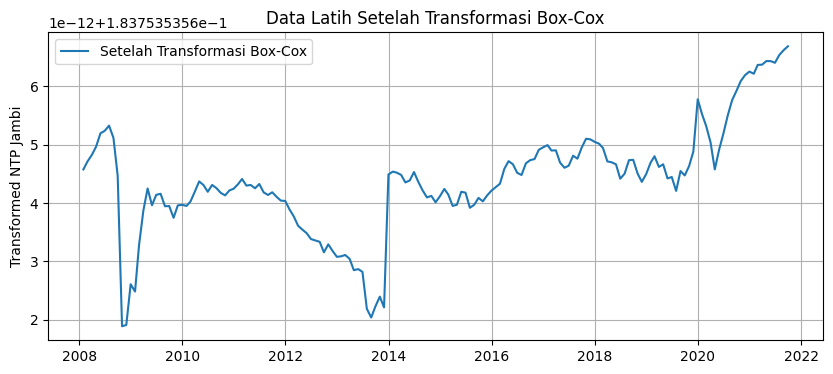

In [63]:
# Estimasi lambda terbaik untuk Box-Cox
train_positive = train[train > 0]  # Pastikan semua nilai positif untuk Box-Cox

train_boxcox, lambda_train = boxcox(train_positive)
print(f"Nilai lambda terbaik (Box-Cox): {lambda_train:.4f}")

# Simpan sebagai Series untuk kemudahan lanjutan
train_boxcox_series = pd.Series(train_boxcox, index=train_positive.index)

# Plot hasil transformasi
plt.figure(figsize=(10, 4))
plt.plot(train_boxcox_series, label="Setelah Transformasi Box-Cox")
plt.title("Data Latih Setelah Transformasi Box-Cox")
plt.ylabel("Transformed NTP Jambi")
plt.grid(True)
plt.legend()
plt.show()


In [64]:
train_boxcox_series

date
2008-01-31    0.183754
2008-02-29    0.183754
2008-03-31    0.183754
2008-04-30    0.183754
2008-05-31    0.183754
2008-06-30    0.183754
2008-07-31    0.183754
2008-08-31    0.183754
2008-09-30    0.183754
2008-10-31    0.183754
2008-11-30    0.183754
2008-12-31    0.183754
2009-01-31    0.183754
2009-02-28    0.183754
2009-03-31    0.183754
2009-04-30    0.183754
2009-05-31    0.183754
2009-06-30    0.183754
2009-07-31    0.183754
2009-08-31    0.183754
2009-09-30    0.183754
2009-10-31    0.183754
2009-11-30    0.183754
2009-12-31    0.183754
2010-01-31    0.183754
2010-02-28    0.183754
2010-03-31    0.183754
2010-04-30    0.183754
2010-05-31    0.183754
2010-06-30    0.183754
2010-07-31    0.183754
2010-08-31    0.183754
2010-09-30    0.183754
2010-10-31    0.183754
2010-11-30    0.183754
2010-12-31    0.183754
2011-01-31    0.183754
2011-02-28    0.183754
2011-03-31    0.183754
2011-04-30    0.183754
2011-05-31    0.183754
2011-06-30    0.183754
2011-07-31    0.183754
2011-0

In [65]:
from datetime import datetime
import pandas as pd

# Generate the date range from 2008-01-31 to 2021-09-30 monthly
dates = pd.date_range(start="2008-01-31", end="2021-09-30", freq='M')
values = [0.183754] * len(dates)

# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Value': values})
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Create a pivot table with years as rows and months as columns
pivot_df = df.pivot(index='Year', columns='Month', values='Value')
pivot_df = pivot_df.rename(columns={
    1: 'Januari', 2: 'Februari', 3: 'Maret', 4: 'April',
    5: 'Mei', 6: 'Juni', 7: 'Juli', 8: 'Agustus',
    9: 'September', 10: 'Oktober', 11: 'November', 12: 'Desember'
})

# Format LaTeX table headers
latex_table = pivot_df.to_latex(index=True, na_rep="", column_format="|c" + "|c"*12 + "|", bold_rows=True)

latex_table[:1000]  # Show part of it to preview, not everything at once



'\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}\n\\toprule\nMonth & Januari & Februari & Maret & April & Mei & Juni & Juli & Agustus & September & Oktober & November & Desember \\\\\nYear &  &  &  &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n\\textbf{2008} & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 \\\\\n\\textbf{2009} & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 \\\\\n\\textbf{2010} & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 \\\\\n\\textbf{2011} & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 \\\\\n\\textbf{2012} & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 & 0.183754 \

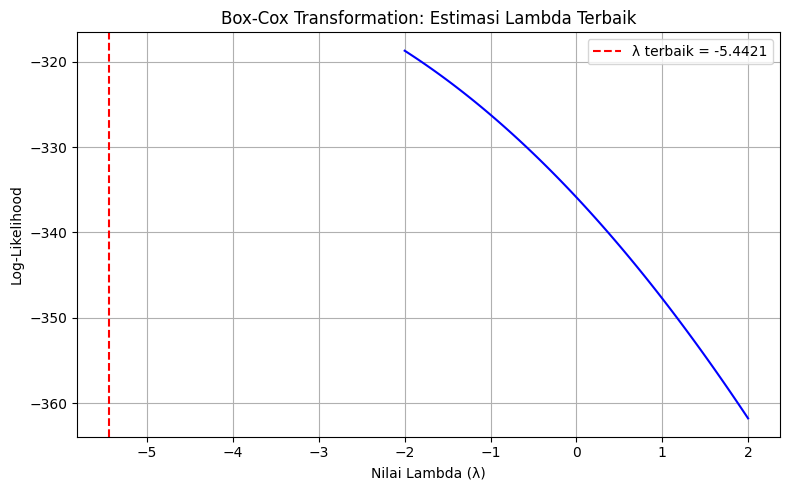

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox, boxcox_normmax, boxcox_llf

# Pastikan data > 0
train_positive = train[train > 0]

# Cari lambda terbaik
lambdas = np.linspace(-2, 2, num=100)
llf = [boxcox_llf(lmb, train_positive) for lmb in lambdas]
best_lambda = boxcox_normmax(train_positive, method='mle')

# Plot grafik Box-Cox
plt.figure(figsize=(8, 5))
plt.plot(lambdas, llf, color='blue')
plt.axvline(best_lambda, color='red', linestyle='--', label=f"λ terbaik = {best_lambda:.4f}")
plt.xlabel('Nilai Lambda (λ)')
plt.ylabel('Log-Likelihood')
plt.title('Box-Cox Transformation: Estimasi Lambda Terbaik')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


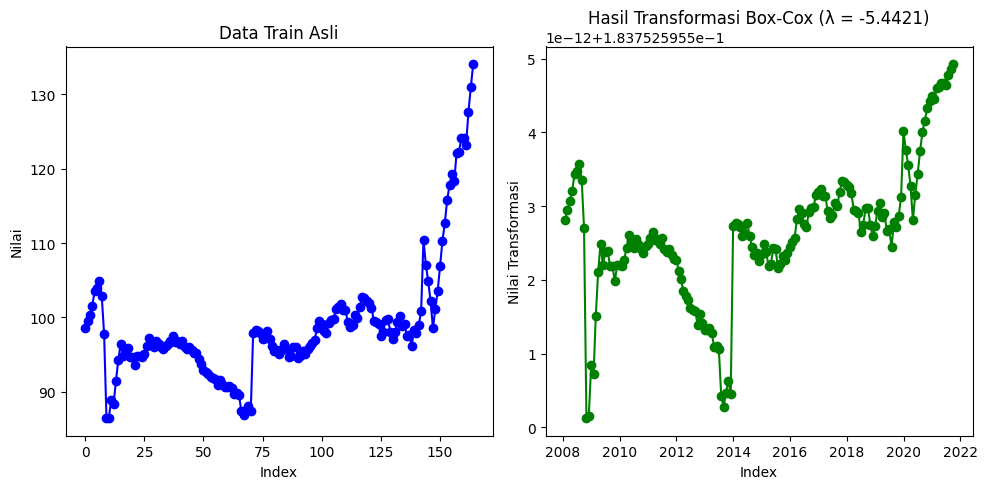

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Misalnya train adalah array atau Series dan sudah didefinisikan
lam = -5.4421
train_positive = train[train > 0]  # Pastikan hanya nilai positif

# Transformasi Box-Cox manual
boxcox_transformed = (np.power(train_positive, lam) - 1) / lam

# Plot sebelum dan sesudah transformasi
plt.figure(figsize=(10, 5))

# Plot original
plt.subplot(1, 2, 1)
plt.plot(train_positive.values, marker='o', linestyle='-', color='blue')
plt.title('Data Train Asli')
plt.xlabel('Index')
plt.ylabel('Nilai')

# Plot hasil transformasi
plt.subplot(1, 2, 2)
plt.plot(boxcox_transformed, marker='o', linestyle='-', color='green')
plt.title('Hasil Transformasi Box-Cox (λ = -5.4421)')
plt.xlabel('Index')
plt.ylabel('Nilai Transformasi')

plt.tight_layout()
plt.show()


In [86]:
boxcox_transformed

date
2008-01-31    0.183753
2008-02-29    0.183753
2008-03-31    0.183753
2008-04-30    0.183753
2008-05-31    0.183753
2008-06-30    0.183753
2008-07-31    0.183753
2008-08-31    0.183753
2008-09-30    0.183753
2008-10-31    0.183753
2008-11-30    0.183753
2008-12-31    0.183753
2009-01-31    0.183753
2009-02-28    0.183753
2009-03-31    0.183753
2009-04-30    0.183753
2009-05-31    0.183753
2009-06-30    0.183753
2009-07-31    0.183753
2009-08-31    0.183753
2009-09-30    0.183753
2009-10-31    0.183753
2009-11-30    0.183753
2009-12-31    0.183753
2010-01-31    0.183753
2010-02-28    0.183753
2010-03-31    0.183753
2010-04-30    0.183753
2010-05-31    0.183753
2010-06-30    0.183753
2010-07-31    0.183753
2010-08-31    0.183753
2010-09-30    0.183753
2010-10-31    0.183753
2010-11-30    0.183753
2010-12-31    0.183753
2011-01-31    0.183753
2011-02-28    0.183753
2011-03-31    0.183753
2011-04-30    0.183753
2011-05-31    0.183753
2011-06-30    0.183753
2011-07-31    0.183753
2011-0

In [67]:
# Uji ADF pada data hasil Box-Cox
result_adf1 = adfuller(train_boxcox_series)
print("ADF Test (tanpa differencing):")
print(f"  ADF Statistic: {result_adf1[0]:.4f}")
print(f"  p-value: {result_adf1[1]:.4f}")



ADF Test (tanpa differencing):
  ADF Statistic: -1.6642
  p-value: 0.4497


In [68]:
train_boxcox

array([0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375354,
       0.18375354, 0.18375354, 0.18375354, 0.18375354, 0.18375

In [69]:
# Uji ADF pada data hasil Box-Cox
result_adf1 = adfuller(train_boxcox_series)
print("ADF Test (tanpa differencing):")
print(f"  ADF Statistic: {result_adf1[0]:.4f}")
print(f"  p-value: {result_adf1[1]:.4f}")

# Jika tidak stasioner, lakukan differencing
diff_train = train_boxcox_series.diff().dropna()
result_adf2 = adfuller(diff_train)
print("\nADF Test (setelah 1x differencing):")
print(f"  ADF Statistic: {result_adf2[0]:.4f}")
print(f"  p-value: {result_adf2[1]:.4f}")


ADF Test (tanpa differencing):
  ADF Statistic: -1.6642
  p-value: 0.4497

ADF Test (setelah 1x differencing):
  ADF Statistic: -11.0776
  p-value: 0.0000


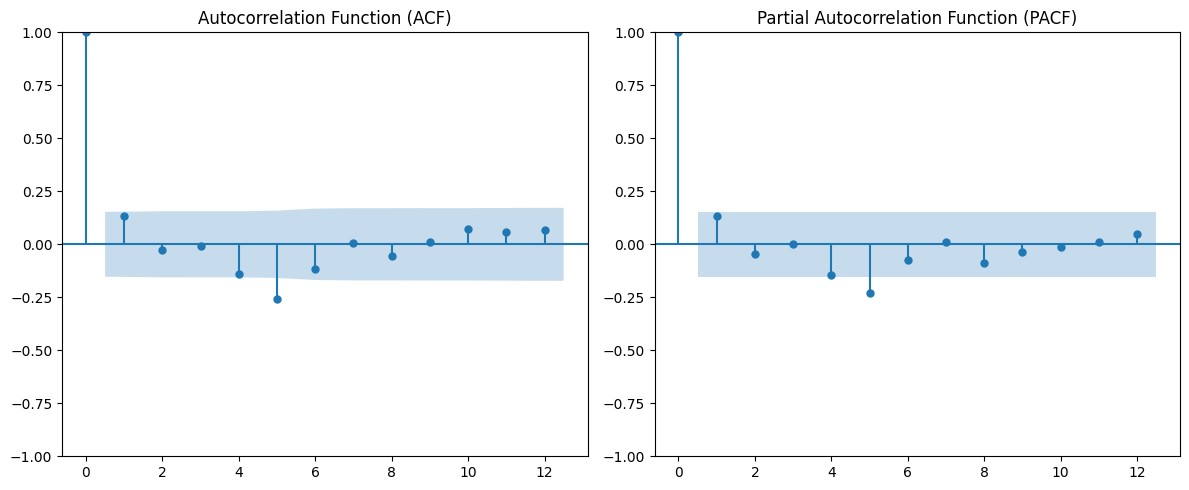

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(diff_train, lags=12, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(diff_train, lags=12, method='ywm', ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [71]:
from statsmodels.tsa.stattools import acf, pacf

# Asumsikan diff_train sudah merupakan data yang ter-differencing
acf_values = acf(diff_train, nlags=12)
pacf_values = pacf(diff_train, nlags=12, method='ywm')

# Cetak hasil ACF
print("ACF Values:")
for i, val in enumerate(acf_values):
    print(f"Lag {i}: {val:.4f}")

# Cetak hasil PACF
print("\nPACF Values:")
for i, val in enumerate(pacf_values):
    print(f"Lag {i}: {val:.4f}")


ACF Values:
Lag 0: 1.0000
Lag 1: 0.1353
Lag 2: -0.0264
Lag 3: -0.0071
Lag 4: -0.1391
Lag 5: -0.2596
Lag 6: -0.1180
Lag 7: 0.0077
Lag 8: -0.0548
Lag 9: 0.0123
Lag 10: 0.0746
Lag 11: 0.0598
Lag 12: 0.0672

PACF Values:
Lag 0: 1.0000
Lag 1: 0.1353
Lag 2: -0.0456
Lag 3: 0.0028
Lag 4: -0.1426
Lag 5: -0.2295
Lag 6: -0.0748
Lag 7: 0.0102
Lag 8: -0.0876
Lag 9: -0.0377
Lag 10: -0.0131
Lag 11: 0.0096
Lag 12: 0.0470


In [72]:
import numpy as np
from statsmodels.tsa.stattools import acf

def manual_pacf(series, nlags):
    rho = acf(series, nlags=nlags, fft=False)  # Autokorelasi hingga lag ke-n
    pacf_matrix = np.zeros((nlags + 1, nlags + 1))
    pacf_matrix[1, 1] = rho[1]  # Lag-1 PACF = ACF
    
    for k in range(2, nlags + 1):
        num = rho[k] - sum(pacf_matrix[k - 1, j] * rho[k - j] for j in range(1, k))
        den = 1 - sum(pacf_matrix[k - 1, j] * rho[j] for j in range(1, k))
        pacf_matrix[k, k] = num / den
        
        # Update nilai phi_k,j untuk j < k
        for j in range(1, k):
            pacf_matrix[k, j] = pacf_matrix[k - 1, j] - pacf_matrix[k, k] * pacf_matrix[k - 1, k - j]
    
    # Ambil hanya nilai PACF pada diagonal (phi_kk)
    pacf_values = [1.0] + [pacf_matrix[k, k] for k in range(1, nlags + 1)]
    return pacf_values


In [73]:
# Misal diff_train sudah tersedia
pacf_vals = manual_pacf(diff_train, nlags=12)

print("PACF (manual Durbin-Levinson):")
for k, val in enumerate(pacf_vals):
    print(f"Lag {k}: {val:.4f}")


PACF (manual Durbin-Levinson):
Lag 0: 1.0000
Lag 1: 0.1353
Lag 2: -0.0456
Lag 3: 0.0028
Lag 4: -0.1426
Lag 5: -0.2295
Lag 6: -0.0748
Lag 7: 0.0102
Lag 8: -0.0876
Lag 9: -0.0377
Lag 10: -0.0131
Lag 11: 0.0096
Lag 12: 0.0470


In [74]:
threshold = 0.1
for k, val in enumerate(pacf_vals):
    if abs(val) > threshold:
        print(f"Lag {k} SIGNIFIKAN: {val:.4f}")
    else:
        print(f"Lag {k} tidak signifikan: {val:.4f}")


Lag 0 SIGNIFIKAN: 1.0000
Lag 1 SIGNIFIKAN: 0.1353
Lag 2 tidak signifikan: -0.0456
Lag 3 tidak signifikan: 0.0028
Lag 4 SIGNIFIKAN: -0.1426
Lag 5 SIGNIFIKAN: -0.2295
Lag 6 tidak signifikan: -0.0748
Lag 7 tidak signifikan: 0.0102
Lag 8 tidak signifikan: -0.0876
Lag 9 tidak signifikan: -0.0377
Lag 10 tidak signifikan: -0.0131
Lag 11 tidak signifikan: 0.0096
Lag 12 tidak signifikan: 0.0470


In [75]:
import numpy as np

def manual_acf(y, nlags):
    y = np.asarray(y)
    n = len(y)
    y_bar = np.mean(y)
    denom = np.sum((y - y_bar)**2)
    
    acf_vals = []
    for k in range(nlags + 1):
        num = np.sum((y[:n - k] - y_bar) * (y[k:] - y_bar))
        rho_k = num / denom
        acf_vals.append(rho_k)
    
    return acf_vals


In [76]:
acf_vals = manual_acf(diff_train, nlags=12)

print("ACF (manual):")
for k, val in enumerate(acf_vals):
    print(f"Lag {k}: {val:.4f}")


ACF (manual):
Lag 0: 1.0000
Lag 1: 0.1353
Lag 2: -0.0264
Lag 3: -0.0071
Lag 4: -0.1391
Lag 5: -0.2596
Lag 6: -0.1180
Lag 7: 0.0077
Lag 8: -0.0548
Lag 9: 0.0123
Lag 10: 0.0746
Lag 11: 0.0598
Lag 12: 0.0672


In [77]:
import numpy as np

def manual_acf_with_significance(series, nlags):
    Y = np.array(series)
    n = len(Y)
    Y_mean = np.mean(Y)
    denom = np.sum((Y - Y_mean) ** 2)
    
    # Confidence Interval (95%)
    ci = 1.96 / np.sqrt(n)
    
    acf_values = []
    for k in range(nlags + 1):
        num = np.sum((Y[:n - k] - Y_mean) * (Y[k:] - Y_mean))
        rho_k = num / denom
        acf_values.append(rho_k)
        
        # Check if the ACF value is significant
        if abs(rho_k) > ci:
            print(f"Lag {k} SIGNIFIKAN: {rho_k:.4f}")
        else:
            print(f"Lag {k} tidak signifikan: {rho_k:.4f}")

    return acf_values


In [78]:
acf_vals = manual_acf_with_significance(diff_train, nlags=24)


Lag 0 SIGNIFIKAN: 1.0000
Lag 1 tidak signifikan: 0.1353
Lag 2 tidak signifikan: -0.0264
Lag 3 tidak signifikan: -0.0071
Lag 4 tidak signifikan: -0.1391
Lag 5 SIGNIFIKAN: -0.2596
Lag 6 tidak signifikan: -0.1180
Lag 7 tidak signifikan: 0.0077
Lag 8 tidak signifikan: -0.0548
Lag 9 tidak signifikan: 0.0123
Lag 10 tidak signifikan: 0.0746
Lag 11 tidak signifikan: 0.0598
Lag 12 tidak signifikan: 0.0672
Lag 13 tidak signifikan: -0.0203
Lag 14 tidak signifikan: 0.0016
Lag 15 tidak signifikan: -0.0410
Lag 16 tidak signifikan: 0.0169
Lag 17 tidak signifikan: -0.0101
Lag 18 tidak signifikan: -0.0736
Lag 19 tidak signifikan: -0.0339
Lag 20 tidak signifikan: 0.0172
Lag 21 tidak signifikan: -0.0219
Lag 22 tidak signifikan: -0.0101
Lag 23 tidak signifikan: 0.0223
Lag 24 tidak signifikan: 0.0297


In [79]:
# Fit model ARIMA pada data training (bukan yang sudah di-difference manual)
model_arima1 = ARIMA(train, order=(5, 1, 0))
result_arima1 = model_arima1.fit()

# Ringkasan model
print(result_arima1.summary())

# AIC dan BIC
print(f"AIC: {result_arima1.aic:.2f}")
print(f"BIC: {result_arima1.bic:.2f}")


                               SARIMAX Results                                
Dep. Variable:              NTP.JAMBI   No. Observations:                  165
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -337.092
Date:                Wed, 04 Jun 2025   AIC                            686.184
Time:                        10:25:48   BIC                            704.783
Sample:                    01-31-2008   HQIC                           693.735
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2149      0.049      4.407      0.000       0.119       0.310
ar.L2          0.0394      0.089      0.442      0.659      -0.135       0.214
ar.L3         -0.0365      0.093     -0.392      0.6

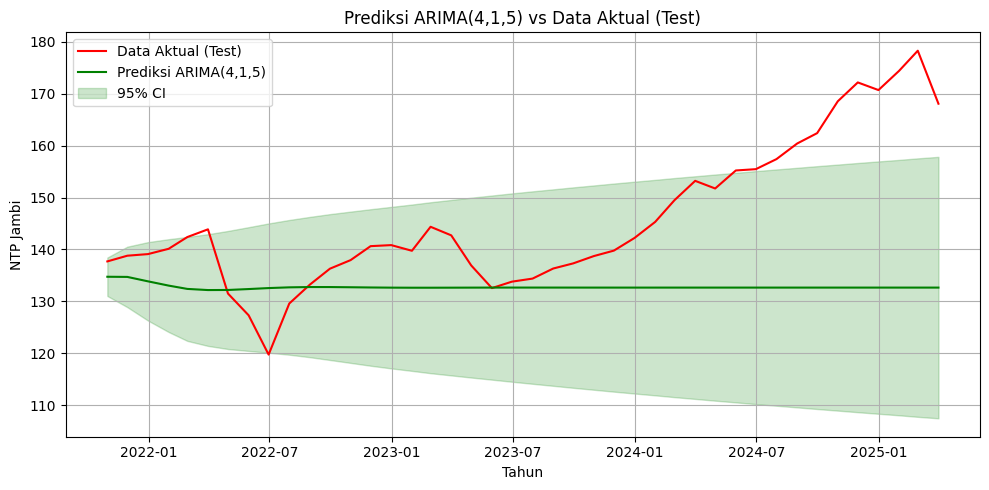

In [80]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Fit model ARIMA(4,1,5) ke data training
model_arima1 = ARIMA(train, order=(5, 1, 0))
result_arima1 = model_arima1.fit()

# 2. Forecast sebanyak panjang data test
h = len(test)
forecast_arima = result_arima1.get_forecast(steps=h)
forecast_mean = forecast_arima.predicted_mean
ci = forecast_arima.conf_int()  # confidence interval

# 3. Plot: Forecast vs Test
plt.figure(figsize=(10, 5))

# Data asli: test set
plt.plot(test.index, test, label="Data Aktual (Test)", color="red")

# Hasil prediksi ARIMA
plt.plot(forecast_mean.index, forecast_mean, label="Prediksi ARIMA(4,1,5)", color="green")

# Confidence interval (band bayangan)
plt.fill_between(forecast_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], 
                 color="green", alpha=0.2, label="95% CI")

# Aksen visual
plt.title("Prediksi ARIMA(4,1,5) vs Data Aktual (Test)")
plt.xlabel("Tahun")
plt.ylabel("NTP Jambi")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Konversi test dan prediksi ke array numerik
actual = np.array(test)
predicted = np.array(forecast_mean)

# MAE
mae_value = mean_absolute_error(actual, predicted)

# MSE
mse_value = mean_squared_error(actual, predicted)

# RMSE
rmse_value = np.sqrt(mse_value)

# MAPE
mape_value = np.mean(np.abs((actual - predicted) / actual)) * 100

# Tampilkan hasil evaluasi
print(f"MAE  : {mae_value:.2f}")
print(f"MSE  : {mse_value:.2f}")
print(f"RMSE : {rmse_value:.2f}")
print(f"MAPE : {mape_value:.2f}%")


MAE  : 14.01
MSE  : 360.64
RMSE : 18.99
MAPE : 8.96%


In [82]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# --- 1. Fit ARIMA dan ambil residual ---
model_arima = ARIMA(train, order=(5, 1, 0))
result_arima = model_arima.fit()
residuals_arima = result_arima.resid

# --- 2. Buat lag features dari residual ARIMA ---
res_df = pd.DataFrame({
    'x1': residuals_arima.shift(1),
    'x2': residuals_arima.shift(2),
    'x3': residuals_arima.shift(3),
    'y': residuals_arima
}).dropna()

# --- 3. Siapkan data untuk ANN ---
X_ann = res_df[['x1', 'x2', 'x3']].values
y_ann = res_df['y'].values

# (opsional) Normalisasi untuk stabilitas training
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_ann)
y_scaled = scaler_y.fit_transform(y_ann.reshape(-1, 1))

# --- 4. Bangun dan latih ANN ---
model_ann = Sequential([
    Dense(10, input_dim=3, activation='relu'),
    Dense(1)  # Output layer (regresi)
])
model_ann.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_ann.fit(X_scaled, y_scaled, epochs=100, verbose=2)

# --- 5. Prediksi residual pada data test (pakai lag terakhir) ---
# Ambil baris lag terakhir sebanyak panjang test
x_pred = res_df[['x1', 'x2', 'x3']].values[-len(test):]
x_pred_scaled = scaler_X.transform(x_pred)
pred_residual_scaled = model_ann.predict(x_pred_scaled)
pred_residual = scaler_y.inverse_transform(pred_residual_scaled).flatten()

# --- 6. Forecast dari ARIMA saja ---
forecast_arima = result_arima.get_forecast(steps=len(test))
arima_forecast = forecast_arima.predicted_mean

# --- 7. Hybrid forecast = ARIMA + ANN (residual correction) ---
final_forecast = arima_forecast.values + pred_residual


Epoch 1/100
6/6 - 0s - loss: 0.1523 - 269ms/epoch - 45ms/step
Epoch 2/100
6/6 - 0s - loss: 0.1316 - 0s/epoch - 0s/step
Epoch 3/100
6/6 - 0s - loss: 0.1125 - 14ms/epoch - 2ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0952 - 0s/epoch - 0s/step
Epoch 5/100
6/6 - 0s - loss: 0.0798 - 17ms/epoch - 3ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0664 - 0s/epoch - 0s/step
Epoch 7/100
6/6 - 0s - loss: 0.0551 - 0s/epoch - 0s/step
Epoch 8/100
6/6 - 0s - loss: 0.0456 - 17ms/epoch - 3ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0380 - 0s/epoch - 0s/step
Epoch 10/100
6/6 - 0s - loss: 0.0316 - 17ms/epoch - 3ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0269 - 0s/epoch - 0s/step
Epoch 12/100
6/6 - 0s - loss: 0.0227 - 0s/epoch - 0s/step
Epoch 13/100
6/6 - 0s - loss: 0.0197 - 17ms/epoch - 3ms/step
Epoch 14/100
6/6 - 0s - loss: 0.0173 - 0s/epoch - 0s/step
Epoch 15/100
6/6 - 0s - loss: 0.0154 - 0s/epoch - 0s/step
Epoch 16/100
6/6 - 0s - loss: 0.0140 - 1ms/epoch - 240us/step
Epoch 17/100
6/6 - 0s - loss: 0.0128 - 0s/epoch - 0s/step

In [83]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# --- Fungsi bantu ---
def create_lags(data, lags=3):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append([data[i-j-1] for j in range(lags)])
        y.append(data[i])
    return np.array(X), np.array(y)

def min_max_scale(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    scaled = (data - min_val) / (max_val - min_val + 1e-8)
    return scaled, min_val, max_val

def min_max_inverse(scaled, min_val, max_val):
    return scaled * (max_val - min_val + 1e-8) + min_val

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# --- Data dummy (ganti dengan data asli) ---
n = 100
np.random.seed(42)
data = np.cumsum(np.random.randn(n))
train = data[:80]
test = data[80:]

# --- 1. Fit ARIMA ---
model_arima = ARIMA(train, order=(5, 1, 0))
result_arima = model_arima.fit()
residuals = result_arima.resid

# --- 2. Lag features dari residual ---
X_ann, y_ann = create_lags(residuals, lags=3)

# --- 3. Normalisasi ---
X_scaled, X_min, X_max = min_max_scale(X_ann)
y_scaled, y_min, y_max = min_max_scale(y_ann.reshape(-1, 1))

# --- 4. Bangun dan latih ANN manual ---
np.random.seed(42)
W1 = np.random.randn(3, 10) * 0.1
b1 = np.zeros((1, 10))
W2 = np.random.randn(10, 1) * 0.1
b2 = np.zeros((1, 1))

lr = 0.001
epochs = 100

for epoch in range(epochs):
    Z1 = X_scaled @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    y_pred = Z2

    loss = np.mean((y_pred - y_scaled)**2)

    dZ2 = 2 * (y_pred - y_scaled) / len(y_scaled)
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X_scaled.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# --- 5. Prediksi residual ANN pada data test ---
res_df = pd.DataFrame({
    'x1': residuals[2:-1],
    'x2': residuals[1:-2],
    'x3': residuals[0:-3]
})
x_pred = res_df.values[-len(test):]
x_pred_scaled = (x_pred - X_min) / (X_max - X_min + 1e-8)

Z1_test = x_pred_scaled @ W1 + b1
A1_test = relu(Z1_test)
Z2_test = A1_test @ W2 + b2
pred_residual_scaled = Z2_test
pred_residual = min_max_inverse(pred_residual_scaled, y_min, y_max).flatten()

# --- 6. Forecast ARIMA ---
forecast_arima = result_arima.get_forecast(steps=len(test))
arima_forecast = forecast_arima.predicted_mean

# --- 7. Hybrid Forecast ---
final_forecast = arima_forecast}] + pred_residual
print("\nFinal Hybrid Forecast:", final_forecast)


SyntaxError: unmatched '}' (2887794598.py, line 102)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# --- 1. Fit ARIMA dan ambil residual ---
model_arima = ARIMA(train, order=(5, 1, 0))
result_arima = model_arima.fit()
residuals_arima = result_arima.resid

# --- 2. Buat lag features dari residual ARIMA ---
res_df = pd.DataFrame({
    'x1': residuals_arima.shift(1),
    'x2': residuals_arima.shift(2),
    'x3': residuals_arima.shift(3),
    'x4': residuals_arima.shift(4),
    'x5': residuals_arima.shift(5),
    'x6': residuals_arima.shift(6),
    'x7': residuals_arima.shift(7),
    'x8': residuals_arima.shift(8),
    'x9': residuals_arima.shift(9),
    'x10': residuals_arima.shift(10),
    'x11': residuals_arima.shift(11),
    'x12': residuals_arima.shift(12),
    'y': residuals_arima
}).dropna()

# --- 3. Siapkan data untuk ANN ---
X_ann = res_df[['x1', 'x2', 'x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']].values
y_ann = res_df['y'].values

# (opsional) Normalisasi untuk stabilitas training
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_ann)
y_scaled = scaler_y.fit_transform(y_ann.reshape(-1, 1))

# --- 4. Bangun dan latih ANN ---
model_ann = Sequential([
    Dense(1000, input_dim=12, activation='relu'),
     Dense(900,activation='relu'),
     Dense(800,activation='relu'),
     Dense(700,activation='relu'),
      Dense(100,activation='relu'),
    Dense(1)  # Output layer (regresi)
])
model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# ✅ Tambahkan ini untuk inisialisasi bobot secara eksplisit
model_ann.build(input_shape=(None, 12))

# Tampilkan bobot awal
for i, layer in enumerate(model_ann.layers):
    weights, biases = layer.get_weights()
    print(f"Layer {i + 1} - Bobot Awal:\n{weights}")
    print(f"Layer {i + 1} - Bias Awal:\n{biases}")

# Lanjut training
model_ann.fit(X_scaled, y_scaled, epochs=500, verbose=2)

# --- 5. Prediksi residual pada data test (pakai lag terakhir) ---
x_pred = res_df[['x1', 'x2', 'x3','x4','x5','x6','x7','x8','x9','x10','x11','x12']].values[-len(test):]
x_pred_scaled = scaler_X.transform(x_pred)
pred_residual_scaled = model_ann.predict(x_pred_scaled)
pred_residual = scaler_y.inverse_transform(pred_residual_scaled).flatten()

# --- 6. Forecast dari ARIMA saja ---
forecast_arima = result_arima.get_forecast(steps=len(test))
arima_forecast = forecast_arima.predicted_mean

# --- 7. Hybrid forecast = ARIMA + ANN (residual correction) ---
final_forecast = arima_forecast.values + pred_residual


Layer 1 - Bobot Awal:
[[-0.00598974 -0.04133914  0.05504356 ...  0.0758578  -0.06743154
   0.00683346]
 [-0.06795572 -0.05907626  0.07285042 ...  0.015796    0.05494614
   0.03315845]
 [ 0.01297766 -0.03148242  0.02416984 ...  0.00587116 -0.0388549
  -0.02917539]
 ...
 [-0.05962456  0.04552449  0.05161175 ... -0.04556584 -0.07297499
  -0.04660321]
 [-0.04316578  0.00014846 -0.04651144 ...  0.0485047   0.04729209
  -0.01893474]
 [-0.01034869 -0.01518701 -0.06641521 ... -0.00925216 -0.0145927
   0.05888095]]
Layer 1 - Bias Awal:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
# --- 8. Tampilkan bobot dan bias ANN ---
weights = model_ann.get_weights()

# Layer pertama (input → hidden)
w1, b1 = weights[0], weights[1]
print("Bobot layer 1 (input → hidden):")
print(w1)
print("Bias layer 1:")
print(b1)

# Layer kedua (hidden → output)
w2, b2 = weights[2], weights[3]
print("\nBobot layer 2 (hidden → output):")
print(w2)
print("Bias layer 2:")
print(b2)


Bobot layer 1 (input → hidden):
[[-0.0166855  -0.04031311  0.05645673 ...  0.07342348 -0.06563002
   0.00309547]
 [-0.05968095 -0.05440693  0.06714948 ...  0.01417696  0.05141731
   0.02841039]
 [ 0.01049338 -0.02309584  0.02098686 ...  0.00116308 -0.03673625
  -0.03393013]
 ...
 [-0.06502599  0.05214443  0.04992088 ... -0.04902925 -0.07674953
  -0.04942545]
 [-0.04531181  0.00196107 -0.04921906 ...  0.04532481  0.04566133
  -0.02082846]
 [-0.01261616 -0.00979665 -0.06917727 ... -0.00840906 -0.01054793
   0.05132984]]
Bias layer 1:
[-4.41122480e-04  6.22149929e-03 -2.51521100e-03  1.45774428e-03
  4.49696265e-04 -5.51720033e-04  2.45851092e-03 -2.39447015e-03
 -8.75408819e-04  0.00000000e+00  0.00000000e+00 -1.05089438e-03
 -2.32003583e-03 -1.66948070e-04  2.48392462e-04  6.00623107e-03
 -1.02800981e-03 -4.76342300e-03  0.00000000e+00 -5.37797483e-03
  4.78787697e-04  9.49291221e-04  0.00000000e+00 -3.65454680e-03
  0.00000000e+00 -4.93661081e-03 -3.08471196e-03  0.00000000e+00
 -2.676

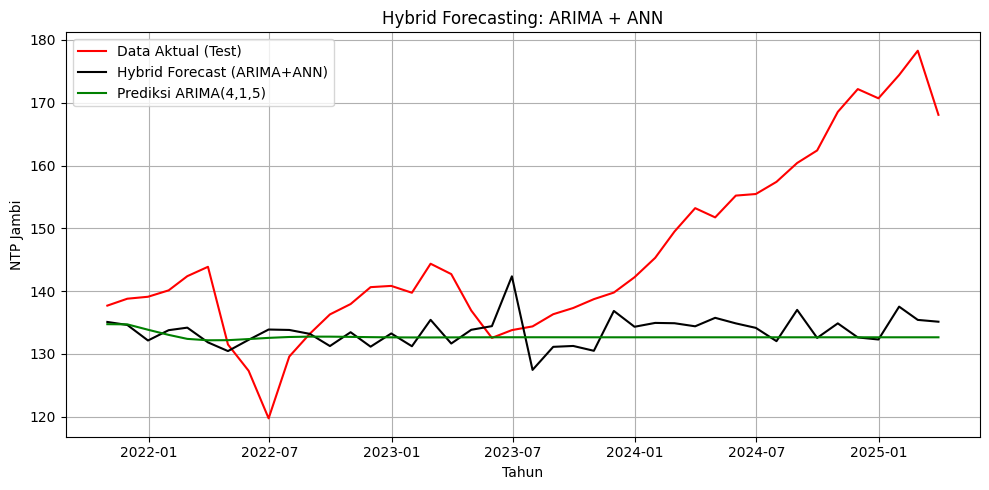

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Data Aktual (Test)', color='red')
plt.plot(test.index, final_forecast, label='Hybrid Forecast (ARIMA+ANN)', color='black')
plt.title('Hybrid Forecasting: ARIMA + ANN')
plt.plot(forecast_mean.index, forecast_mean, label="Prediksi ARIMA(4,1,5)", color="green")

plt.xlabel('Tahun')
plt.ylabel('NTP Jambi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- EVALUASI (MSE, MAE, RMSE, MAPE) ---
mse = np.mean((test - final_forecast) ** 2)  # MSE
mae = np.mean(np.abs(test - final_forecast))  # MAE
rmse = np.sqrt(mse)  # RMSE
mape = np.mean(np.abs((test - final_forecast) / test)) * 100  # MAPE

# Tampilkan hasil evaluasi
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f}%")


MAE   : 13.6878
MSE   : 326.3943
RMSE  : 18.0664
MAPE  : 8.82%


In [ ]:
forecast_mean

2021-10-31    134.734087
2021-11-30    134.703260
2021-12-31    133.850335
2022-01-31    133.029561
2022-02-28    132.392562
2022-03-31    132.170759
2022-04-30    132.187375
2022-05-31    132.364318
2022-06-30    132.553998
2022-07-31    132.694262
2022-08-31    132.751729
2022-09-30    132.749092
2022-10-31    132.711448
2022-11-30    132.668585
2022-12-31    132.636916
2023-01-31    132.622870
2023-02-28    132.622949
2023-03-31    132.631012
2023-04-30    132.640620
2023-05-31    132.647826
2023-06-30    132.651189
2023-07-31    132.651309
2023-08-31    132.649582
2023-09-30    132.647437
2023-10-31    132.645794
2023-11-30    132.644996
2023-12-31    132.644936
2024-01-31    132.645305
2024-02-29    132.645783
2024-03-31    132.646157
2024-04-30    132.646346
2024-05-31    132.646367
2024-06-30    132.646288
2024-07-31    132.646182
2024-08-31    132.646097
2024-09-30    132.646052
2024-10-31    132.646046
2024-11-30    132.646063
2024-12-31    132.646086
2025-01-31    132.646106


2/2 [==============================] - 0s 7ms/step
MAE   : 4.1193
MSE   : 32.5225
RMSE  : 5.7029
MAPE  : 2.88%


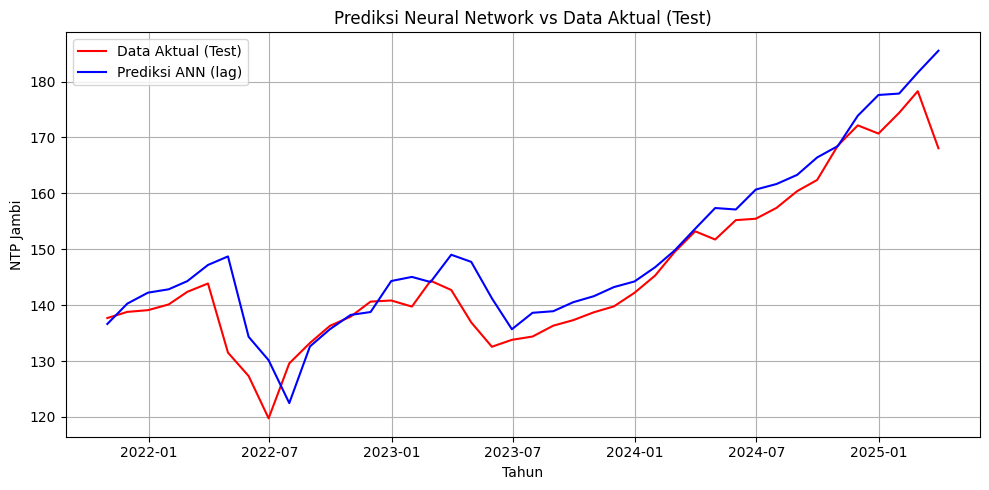

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# === 1. Buat fungsi untuk membuat window lag ===
def create_lagged_data(series, lag=5):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# === 2. Data dan Preprocessing ===
# Asumsikan 'data' adalah DataFrame atau Series NTP yang sudah kamu siapkan
# Contoh dummy (ganti ini dengan data kamu!)
data = pd.Series(train.tolist() + test.tolist(), index=pd.date_range(start="2008", periods=len(train)+len(test), freq="M"))

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

# Tentukan lag
lag = 5
X_all, y_all = create_lagged_data(data_scaled, lag=lag)

# Split ke train dan test (harus sejajar dengan split awal)
train_size = len(train) - lag  # karena offset oleh lag
X_train, y_train = X_all[:train_size], y_all[:train_size]
X_test, y_test = X_all[train_size:], y_all[train_size:]

# === 3. Bangun model ANN ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(lag,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, verbose=0)

# === 4. Prediksi ===
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# === 5. Evaluasi ===
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_pred) * 100

print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f}%")

# === 6. Plot ===
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_test_actual, label="Data Aktual (Test)", color='red')
plt.plot(test.index, y_pred, label="Prediksi ANN (lag)", color='blue')
plt.title("Prediksi Neural Network vs Data Aktual (Test)")
plt.xlabel("Tahun")
plt.ylabel("NTP Jambi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
data

2008-01-31     98.55
2008-02-29     99.53
2008-03-31    100.39
2008-04-30    101.54
2008-05-31    103.61
               ...  
2024-11-30    172.17
2024-12-31    170.70
2025-01-31    174.41
2025-02-28    178.28
2025-03-31    168.07
Freq: M, Length: 207, dtype: float64

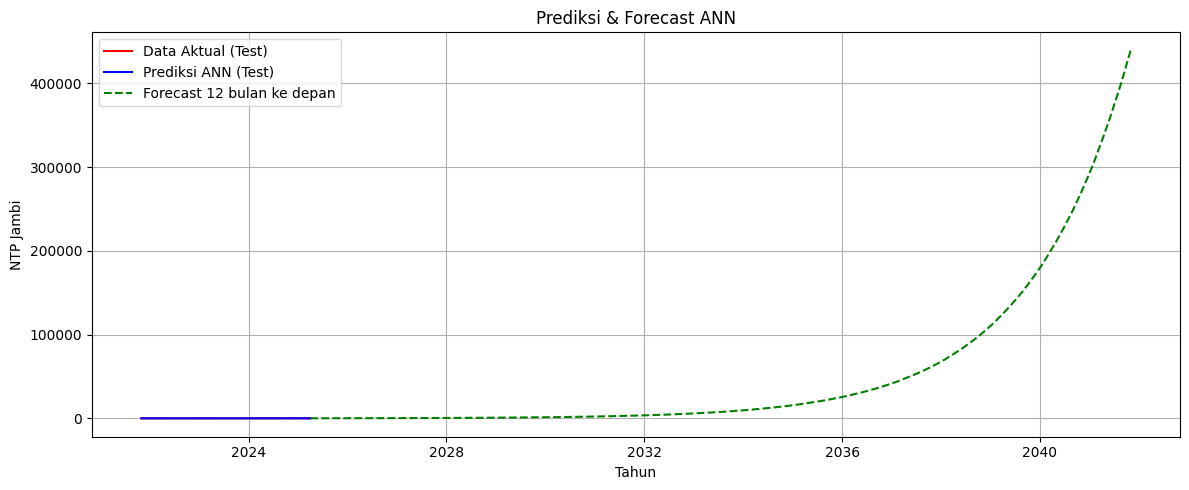

In [ ]:
# === 5b. Prediksi ke depan sebanyak 12 bulan ===
n_forecast = 200
future_preds = []

# Mulai dari akhir data test
last_input = X_test[-1].tolist()  # Ambil window terakhir sebagai input awal

for _ in range(n_forecast):
    pred_scaled = model.predict(np.array([last_input]), verbose=0).flatten()[0]
    future_preds.append(pred_scaled)

    # Geser window dengan menambahkan prediksi terbaru
    last_input = last_input[1:] + [pred_scaled]

# Balikkan skala ke bentuk asli
future_preds_actual = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

# Buat indeks waktu untuk prediksi 12 bulan ke depan
last_date = data.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(years=0), periods=n_forecast, freq="M")

# === 6b. Gabung hasil prediksi ke plot sebelumnya ===
plt.figure(figsize=(12, 5))
plt.plot(data.index[-len(test):], y_test_actual, label="Data Aktual (Test)", color='red')
plt.plot(data.index[-len(test):], y_pred, label="Prediksi ANN (Test)", color='blue')
plt.plot(future_index, future_preds_actual, label="Forecast 12 bulan ke depan", linestyle='--', color='green')
plt.title("Prediksi & Forecast ANN")
plt.xlabel("Tahun")
plt.ylabel("NTP Jambi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
future_preds_actual

array([1.85527405e+02, 1.91381592e+02, 1.96810791e+02, 2.02557602e+02,
       2.08677338e+02, 2.15447525e+02, 2.22392258e+02, 2.29470978e+02,
       2.36814255e+02, 2.44490402e+02, 2.52546326e+02, 2.60936768e+02,
       2.69650970e+02, 2.78715637e+02, 2.88159912e+02, 2.98006287e+02,
       3.08263947e+02, 3.18944336e+02, 3.30065643e+02, 3.41648865e+02,
       3.53714752e+02, 3.66282501e+02, 3.79371857e+02, 3.93004486e+02,
       4.07203156e+02, 4.21991852e+02, 4.37395020e+02, 4.53437866e+02,
       4.70147095e+02, 4.87550293e+02, 5.05676392e+02, 5.24555420e+02,
       5.44218628e+02, 5.64698486e+02, 5.86029114e+02, 6.08245728e+02,
       6.31385071e+02, 6.55485535e+02, 6.80587158e+02, 7.06731323e+02,
       7.33961548e+02, 7.62322693e+02, 7.91862000e+02, 8.22628174e+02,
       8.54672363e+02, 8.88047546e+02, 9.22808838e+02, 9.59014221e+02,
       9.96723389e+02, 1.03599878e+03, 1.07690564e+03, 1.11951160e+03,
       1.16388733e+03, 1.21010632e+03, 1.25824487e+03, 1.30838293e+03,
      